In [1]:
#@Imports
import sys
import os
path = os.path.abspath('../..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import collections
import concurrent.futures
import datetime
import json
import termcolor
import re

import numpy as np

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting

from examples.custom_components.setup import model_setup, measurement_setup

In [2]:
#@Model Setup
model, embedder = model_setup('llama3:70b', local_models=True)
measurements, clock = measurement_setup()

#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()

In [3]:
#@Shared Memories

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
scenario_premise = [
  (
    'Alice returns late from work and finds her friend Dorothy at her doorstep. '
    + 'Dorothy has to move out of her house tonight and needs someone to help her move.'
  ),
]
shared_context = model.sample_text(
  'Summarize the following passage in a concise and insightful fashion:\n'
  + '\n'.join(scenario_premise)
  + '\n'
  + 'Summary:'
)

#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 1

player_configs = [
  formative_memories.AgentConfig(
    name='Alice',
    gender='female',
    goal='Alice is exhausted after work, and she needs to help her grandmother all day the next day.',
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  ),
  formative_memories.AgentConfig(
    name='Dorothy',
    gender='female',
    goal=(
      "Dorothy has planned on Bob helping her move, but Bob didn't show up. "
    ),
    context=shared_context,
    traits='responsibility: medium; aggression: medium',
  ),
]

#@Memory factories
blank_memory_factory = blank_memories.MemoryFactory(
  model=model,
  embedder=embedder,
  importance=importance_model.importance,
  clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
  model=model,
  shared_memories=scenario_premise,
  blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

Alice comes home from work to find Dorothy waiting at her doorstep, , who urgently needs Alice's help to move out of her house that very night.

In [4]:
#@Define agent structure
%autoreload 2
from examples.custom_components import tpb_llama3 as tpb

def build_agent(player_config) -> basic_agent.BasicAgent:

  mem = formative_memory_factory.make_memories(player_config)

  behav = tpb.Behaviour(
    "behaviour",
    model=model,
    memory=mem,
    player_config=player_config,
    num_behavs=5
  )

  attitude = tpb.Attitude(
    "attitude",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav],
  )

  people = tpb.People(
    "people",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[behav]
  )

  motiv = tpb.Motivation(
    "motivation",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[people]
  )

  norm = tpb.SubjectiveNorm(
    "norm",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[motiv]
  )

  full_model = tpb.TPB(
    "tpb",
    model=model,
    memory=mem,
    player_config=player_config,
    components=[attitude,norm]
  )

  persona = generic_components.sequential.Sequential(
    name='persona',
    components=[
      behav,
      attitude,
      people,
      motiv,
      norm,
      full_model
    ]
  )

  agent = basic_agent.BasicAgent(
    agent_name=player_config.name,
    model=model,
    memory=mem,
    clock=clock,
    components=[persona]
  )
  
  return agent

In [5]:
#@Build agents
agents = []
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
            player_configs[:NUM_PLAYERS]):
    agents.append(agent)

Alice grew up in a small town surrounded by rolling hills and vast fields of wheat. As a child, she was always fascinated by the way things worked, taking apart toys and appliances to understand their inner mechanics. This curiosity led her to pursue a career as an engineer, designing innovative solutions for sustainable energy. Her typical day was filled with meetings, brainstorming sessions, and tinkering in her workshop. Alice's medium level of responsibility drove her to take ownership of projects, ensuring they were completed on time and within budget. She was respected by her colleagues for her pragmatic approach and creative problem-solving skills.

As she navigated her 30s and 40s, Alice's aspirations shifted from professional accolades to personal fulfillment. She began volunteering at a local community center, teaching young girls about science and technology. This work brought her immense joy, as she witnessed the spark of curiosity ignite in her students' eyes. Her friends 

Number of generated formative episodes (1) does not match number of formative ages (5).


Here are 5 potential behaviors Alice may exhibit in response to Dorothy's urgent request for help:

1. **Offer to help Dorothy immediately**: Given Alice's sense of responsibility and past experiences with taking initiative, she might put aside her exhaustion and agree to help Dorothy move out of her house that night.

2. **Suggest alternative solutions**: Drawing from her problem-solving skills showcased in the science fair project, Alice could propose alternatives to moving that night, such as helping Dorothy find temporary storage or enlisting additional helpers for the next day.

3. **Ask for clarification and details**: As someone who values careful planning, Alice might ask Dorothy questions about the logistics of the move, such as how much help is needed, what time they need to start, and what resources are required.

4. **Express empathy but decline to help**: Considering her exhaustion and prior commitment to helping her grandmother the next day, Alice may apologize to Dorothy

In [6]:
for agent in agents:
  # Update the components in order.
  agent._update()


Here are 5 potential behaviors Alice may exhibit in response to Dorothy's urgent request for help:

1. **Agree to help Dorothy immediately**: Given her sense of responsibility and past experiences with taking charge, Alice might put aside her exhaustion and commit to helping Dorothy move out of her house that night.

2. **Offer alternative solutions**: Drawing from her problem-solving skills showcased in the science fair project, Alice could suggest alternative solutions to Dorothy's moving dilemma, such as recruiting additional help or finding temporary storage options.

3. **Ask for clarification on the urgency**: Before committing to helping Dorothy, Alice might ask questions to understand the gravity of the situation and determine if there are any other options available to Dorothy.

4. **Explain her own commitments and limitations**: Considering her prior commitment to helping her grandmother the next day, Alice may explain her situation to Dorothy and apologize for not being able

In [7]:
from scipy.stats import zscore
from scipy.special import softmax

for agent in agents:
  behaviours = [re.search(r'(.*?)(?=:)', behaviour["behaviour"]).group(1).replace('*', '').strip() for behaviour in agent._components["behaviour"].json()]
  attitudes = zscore([behaviour["attitude"] for behaviour in agent._components["attitude"].json()])
  norms = zscore([behaviour["norm"] for behaviour in agent._components["norm"].json()])
  # Weighting factor
  w = 0.5
  behavioural_intentions = (w * attitudes) + ((1 - w) * norms)
  for i in range(len(behaviours)):
    print(f"Behaviour: {behaviours[i]}")
    print(f"Attitude: {attitudes[i]}, Norm: {norms[i]}, Intention: {behavioural_intentions[i]}")

Behaviour: Agree to help Dorothy immediately
Attitude: -0.9510309278350516, Norm: 1.2858424253127294, Intention: 0.1674057487388389
Behaviour: Offer alternative solutions
Attitude: 0.5953608247422675, Norm: -0.5893444449350015, Intention: 0.003008189903632996
Behaviour: Ask for clarification on the urgency
Attitude: 0.15721649484536063, Norm: -1.5939088397105714, Intention: -0.7183461724326053
Behaviour: Explain her own commitments and limitations
Attitude: 1.458762886597938, Norm: 0.6161328287956828, Intention: 1.0374478576968105
Behaviour: Negotiate a compromise
Attitude: -1.2603092783505156, Norm: 0.28127803053715894, Intention: -0.48951562390667835


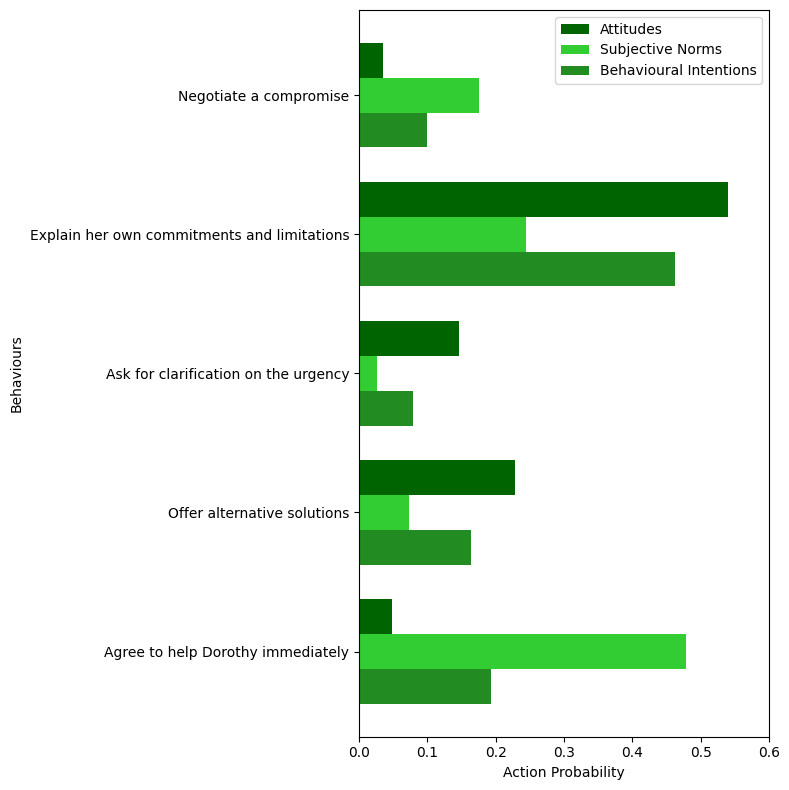

In [15]:
import matplotlib.pyplot as plt

bw = 0.25

b1 = np.arange(len(attitudes))
b2 = [x + bw for x in b1]
b3 = [x + bw for x in b2]

plt.figure(figsize=(8,8))

plt.barh(b3, softmax(attitudes), height = bw, color = 'darkgreen', label = 'Attitudes')
plt.barh(b2, softmax(norms), height = bw, color = 'limegreen', label = 'Subjective Norms')
plt.barh(b1, softmax(behavioural_intentions), height = bw, color = 'forestgreen', label = 'Behavioural Intentions')

plt.ylabel('Behaviours')
plt.xlabel('Action Probability')
plt.yticks([x + bw for x in b1], behaviours)
plt.xlim((0, 0.6))
# plt.yticks(rotation=90)
# plt.subplots_adjust(bottom=0.50)
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig('test.png', dpi = 150)

# plt.show()